### Introduction

The Galaxy Evolution Explorer (GALEX) is a NASA mission that observed between July 7, 2003 and February 7, 2012 with the goal of investigating star formation evolution in galaxies from the early Universe to present day. With a 1.25 degree field-of-view, the telescope took direct images in the near-UV (NUV) and far-UV (FUV) wavelengths using microchannel plate detectors, and low resolution spectroscopy was obtained using a grism. Data was collected as time-tagged photon events and science data was only taken while behind Earth’s shadow (referred to as an “eclipse”).

These data are now available in the public S3 bucket on AWS and can be accessed anonymously through astroquery.mast.Observations. The S3 path for GALEX data is s3://stpubdata/galex and the data volume hosted there is approximately 21 TB of GR 6 and 7 data cumulatively.

### GALEX data cloud access with `astroquery.mast`

The data currently available are Galaxy Release (GR) 6 and 7. Users can verify whether or not their products are in the cloud by making a call to astroquery.mast.Observations.get_cloud_uri (for a single product) or astroquery.mast.Observations.get_cloud_uris (for multiple products).

Below we will run a simple example of accessing GALEX data from the cloud using `astroquery.mast`.

We begin by querying for program 31411 using the query_criteria method in `astroquery.mast.Observations`.

In [2]:
from astroquery.mast import Observations

observations = Observations.query_criteria(obsid='31411')

The output to this query_criteria call is seen below. It is a GALEX program that observed the target M1.

In [3]:
observations

dataproduct_type,calib_level,obs_collection,obs_id,target_name,s_ra,s_dec,t_min,t_max,t_exptime,wavelength_region,filters,em_min,em_max,target_classification,obs_title,t_obs_release,instrument_name,proposal_pi,proposal_id,proposal_type,project,sequence_number,provenance_name,s_region,jpegURL,dataURL,dataRights,mtFlag,srcDen,intentType,obsid,objID
str5,int64,str5,str19,str12,float64,float64,float64,float64,float64,str2,str3,float64,float64,str1,str1,float64,str5,str1,str1,str3,str3,int64,str3,str43,str117,str112,str6,bool,float64,str7,str5,str5
image,2,GALEX,6381787756527353856,AIS_309_1_28,83.49715416019251,22.0648638252376,55894.42565972222,55894.49506944444,167.0,UV,NUV,169300000000.0,300700000000.0,--,--,56188.7607291,GALEX,--,--,AIS,AIS,--,AIS,CIRCLE ICRS 83.49715416 22.06486383 0.625,http://galex.stsci.edu/data/GR6/pipe/02-vsn/50309-AIS_309/d/01-main/0001-img/07-try/qa/AIS_309_sg28-xd-int_2color.jpg,http://galex.stsci.edu/data/GR6/pipe/02-vsn/50309-AIS_309/d/01-main/0001-img/07-try/AIS_309_sg28-xd-mcat.fits.gz,PUBLIC,--,5885.0,science,31411,54974


The next goal is to find the products that correspond to this observation which we will do with the get_product_list method in astroquery.mast.Observations. Products will be filtered further using filter_products to return only science products.

In [5]:
products = Observations.get_product_list(observations[0])
filtered = Observations.filter_products(products,
                                        productType='SCIENCE')

print(filtered)

obsID  obs_collection dataproduct_type ... parent_obsid dataRights calib_level
------ -------------- ---------------- ... ------------ ---------- -----------
113214          GALEX            image ...        31411     PUBLIC           2
113215          GALEX            image ...        31411     PUBLIC           2
 31411          GALEX            image ...        31411     PUBLIC           2


From here, users can download the desired products from the cloud by calling `astroquery.mast.Observations.download_products` and setting the `cloud_only` parameter to `True`. Remember that to pull GALEX data from the cloud, anonymous cloud access must be enabled via the `Observations.enable_cloud_dataset()` call, otherwise the download will default to pulling from the MAST Portal.

In [6]:
# Enabling anonymous cloud access to public s3 bucket
Observations.enable_cloud_dataset()

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


If download location is not specified, products will be downloaded in the current working directory and stored under a generated `mastDownload` folder.

In [7]:
# Downloading files 
Observations.download_products(filtered, cloud_only=True)

Local Path,Status,Message,URL
str73,str8,object,object
./mastDownload/GALEX/6381787619088400384/AIS_309_0001_sg28-nd-int.fits.gz,COMPLETE,None,None
./mastDownload/GALEX/6381787619121954816/AIS_309_0002_sg28-nd-int.fits.gz,COMPLETE,None,None
./mastDownload/GALEX/6381787756527353856/AIS_309_sg28-nd-int.fits.gz,COMPLETE,None,None


### Handling retrieved GALEX data

The data will be downloaded compressed via GNU zip, but content can be handled with astropy.io.fits the same way a non-compressed FITS file would be handled. [See here](https://docs.astropy.org/en/stable/io/fits/usage/unfamiliar.html#compressed-image-data) for more information on handling compressed files with `astropy.io.fits`.

As shown in the output above, the delimited filetype descriptor `nd-int` is shown in the file suffix of all the filenames, denoting that these are intensity maps (J2000) in NUV of the full GALEX FOV in counts per second per pixel, corrected for relative response ([source](http://galex.stsci.edu/gr6/?page=ddfaq)). Let's inspect these files to verify that is the case.

Filename: ./mastDownload/GALEX/6381787619121954816/AIS_309_0002_sg28-nd-int.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   (3840, 3840)   float32   
None
Filename: ./mastDownload/GALEX/6381787756527353856/AIS_309_sg28-nd-int.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     122   (3840, 3840)   float32   
None
Filename: ./mastDownload/GALEX/6381787619088400384/AIS_309_0001_sg28-nd-int.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     215   (3840, 3840)   float32   
None


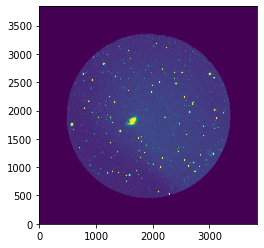

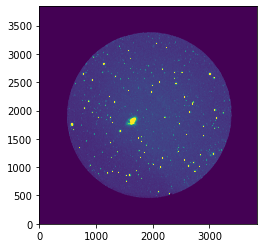

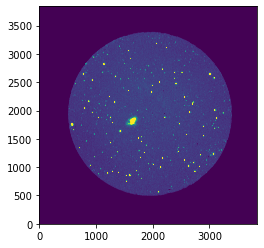

In [40]:
from astropy.io import fits
from glob import glob

files = glob('./mastDownload/GALEX/*/*.fits*')

for file, n in zip(files, range(0, 3)):
    print(fits.info(file))
    data = fits.getdata(file)
    
    plt.figure(n)
    plt.imshow(data, vmin=0, vmax=0.1, origin='lower')

From this we can see that all the files were downloaded properly without any corruption to data, and can be handled as you would a non-compressed FITS file. 